In [6]:
def karatecheck(embed): ## karate 그래프 embedding 효과 유무 확인 위한 시각화 코드
    
    fx_list = []
    fy_list = []
    fl_list = []
    gx_list = []
    gy_list = []
    gl_list = []
    for i in range(len(embed)):
        if i in [0,1,2,3,4,5,6,7,8,10,11,12,13,16,17,19,21]:
            fx_list.append(embed[i][0])
            fy_list.append(embed[i][1])
            fl_list.append(i)
        else:
            gx_list.append(embed[i][0])
            gy_list.append(embed[i][1])
            gl_list.append(i)
    
    group1 = [fx_list, fy_list, fl_list]
    group2 = [gx_list, gy_list, gl_list]
    groups = [group1, group2]
    
    fig, ax = plt.subplots()
    for group in groups:
        ax.plot(group[0], group[1], marker='o', linestyle='', ms=15,)
        for i, text in enumerate(group[2]):
            ax.annotate(text, xy = (group[0][i], group[1][i]))
    plt.title('ephoch = {lamda}, K = {K}, NK ={NK}, p = {p}, q = {q}'. format(lamda = lamda, K = K, NK = NK, LR = LR, p = p, q = q))
    return plt.show()

In [1]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import time

In [8]:
# Graph Data => networkx 로 입력

In [9]:
# WW = [0.1, 0.2, 0.3, 0.4]

In [10]:
def aliastable(PPP):
    
    K = len(PPP)
    L = list(np.zeros(K, dtype = np.int))
    P = list(np.array(PPP.copy(), dtype = np.double)*K)
#     print(P)
    under = []
    over = []
    for index, prob in enumerate(P):
        if prob < 1:
            under.append((index,prob))
        elif prob > 1:
            over.append((index,prob)) 
        while over != [] and under !=[]:
            u = under.pop()
            o = over.pop()
            L[u[0]] = o[0]
            e = o[1] - (1 - u[1]) 
            if e == 1: P[o[0]] = 1
            elif e <1:
                P[o[0]] = e
                under.append((o[0], e))
            else:
                P[o[0]] = e
                over.append((o[0], e))
    return L, P
                


In [11]:
#  aliastable(WW)

In [12]:
# G = nx.karate_club_graph() # karate graph 는 weight 가 없다
# weight 가 있는 일반적인 상황을 고려하고자 아래와 같이 uniform weight 를 부여하였다.
G = nx.karate_club_graph() # karate 가 아니여도, 애초에 networkx 를 통해 그래프를 만들어두면 편리함
A = G.copy()
Temp = []
for x,y in A.edges:
    Temp.append([x,y])
Weight = []
for i in range(len(A.edges)):
    Temp[i].append(1)
    Weight.append(Temp[i])
A.add_weighted_edges_from(Weight)

In [13]:
# nx.shortest_path_length(A, source = 4, target = 18)

In [14]:
# length = []
# for x in range(34):
#     for y in range(34):
#         length.append(nx.shortest_path_length(A, source = x, target = y))
# print(length)
# print(np.average(length))

In [15]:
# a =  [1,2,3,4]
# np.average(a)

In [19]:
adj_list = []
for i in range(len(A.nodes)):
    adj_list.append(list(dict(A.adj[i]).keys()))
NON = 34
in_adj_list = adj_list
p = 2.0
q = 0.2

temp = []
for i in range(NON):
    temp.append([])
    for _ in range(len(in_adj_list[i])+1):
        temp[-1].append([])
        
for v in range(NON):
    for t in range(len(in_adj_list[v])):
        for x in range(len(adj_list[v])):
            if adj_list[v][x] == in_adj_list[v][t]:
                temp[v][t].append(float(A.adj[v][adj_list[v][x]]['weight'])*(1/p))
            elif adj_list[v][x] in adj_list[in_adj_list[v][t]]:
                temp[v][t].append(float(A.adj[v][adj_list[v][x]]['weight'])*1)
            else:
                temp[v][t].append(float(A.adj[v][adj_list[v][x]]['weight'])*(1/q))
    for x in range(len(adj_list[v])):
        temp[v][-1].append(float(A.adj[v][adj_list[v][x]]['weight'])*1)
        
    for tt in range(len(temp[v])):
        temp[v][tt] = list(np.array(temp[v][tt])/sum(temp[v][tt]))    

In [20]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import time

class n2v:
    def __init__(self, G, dim, walks_per_node, length, context_size, NK, p, q, LR):
        self.G = G # G는 weighted, directed graph 를 기준으로 코드를 구현. #undirected graph도 무리없이 작동
                    # unweight 그래프면 uniform weighted graph 로 만들어준다. 방법은 아래 코드 참조 
                    # Temp = []
                    # for x,y in A.edges:
                    #     Temp.append([x,y])
                    # Weight = []
                    # for i in range(len(A.edges)):
                    #     Temp[i].append(1)
                    #     Weight.append(Temp[i])
                    # A.add_weighted_edges_from(Weight)

        self.dim = dim # 논문 참조
        self.lamda = walks_per_node # 논문 참조
        self.length = length # 논문 참조 
        self.K = context_size # 논문 참조 (Line의 K와 다름의 유의)
        self.NK = NK # negative sampling 갯수 (Line 기준 K)
        self.p = p # 논문 참조
        self.q = q # 논문 참조
        self.LR = LR # Learning Rate
        self.adj = G.adj # adj list 를 뽑아내는 networkx 의 method
        self.edges = G.edges 
        self.nodes = G.nodes
        self.NON = len(G.nodes) # NON = number of nodes
# 이후 만들어줄 것
        self.preprocessed = None 
        self.walks = None 
        self.aliastable_index = None 
        self.aliastable_prob = None
             
        self.phi = np.array(np.random.rand(self.NON, self.dim))
        for i in self.phi: 
            i = np.array(i)

        self.adj_list = []
        for i in range(len(A.nodes)): self.adj_list.append(list(dict(self.G.adj[i]).keys()))
        
        self.in_adj_list = []
        for i in range(self.NON):
            self.in_adj_list.append([])
            for j in range(self.NON):
                if i in adj_list[j]: 
                    self.in_adj_list[-1].append(j)
                    
#       아래는 negative sampling 시 필요한 alias preprocess (크기가 작아 생성 작업에 둠.)         
        self.OD = [] # out_degree
        self.ND = [] # noise draistribution
        for _ in range(len(self.adj_list)):  
            self.OD.append(len(self.adj_list[_]))
            self.ND.append(float(len(self.adj_list[_]))**(3/4))
        
        Deno = sum(self.ND)
        for _ in range(len(self.ND)):
            self.ND[_] = self.ND[_]/Deno
        
        self.ns_alias_index, self.ns_alias_prob  = self.aliasmake(self.ND)

    def preprocessforNS(self): # negative sampling 을 위한 preprocess
        pass
                        
    def preprocess(self): # prob distribution 을 만들어냄.
        start = time.time()
        self.preprocessed = []
        for i in range(self.NON):
            self.preprocessed.append([])
            for _ in range(len(self.in_adj_list[i])+1):
                self.preprocessed[-1].append([])
                
        for v in range(self.NON):
            for t in range(len(self.in_adj_list[v])):
                for x in range(len(self.adj_list[v])):
                    if self.adj_list[v][x] == self.in_adj_list[v][t]:
                        self.preprocessed[v][t].append(float(self.G.adj[v][self.adj_list[v][x]]['weight'])*(1/p))
                    elif self.adj_list[v][x] in adj_list[in_adj_list[v][t]]:
                        self.preprocessed[v][t].append(float(self.G.adj[v][self.adj_list[v][x]]['weight'])*1)
                    else:
                        self.preprocessed[v][t].append(float(self.G.adj[v][self.adj_list[v][x]]['weight'])*(1/q))
            for x in range(len(self.adj_list[v])):
                self.preprocessed[v][-1].append(float(self.G.adj[v][self.adj_list[v][x]]['weight'])*1)

            for tt in range(len(self.preprocessed[v])):
                self.preprocessed[v][tt] = list(np.array(self.preprocessed[v][tt])/sum(self.preprocessed[v][tt]))     
        print("Preprocessing time_making prob :", time.time()-start)
        # self.preprocessed 가 완성되어야함
    
        def aliasmake(self, PPP):
            K = len(PPP)
            L = list(np.zeros(K, dtype = np.int))
            P = list(np.array(PPP.copy(), dtype = np.double)*K)
    #         print(P)
            under = []
            over = []
            for index, prob in enumerate(P):
                if prob < 1:
                    under.append((index,prob))
                elif prob > 1:
                    over.append((index,prob)) 
                while over != [] and under !=[]:
                    u = under.pop()
                    o = over.pop()
                    L[u[0]] = o[0]
                    e = o[1] - (1 - u[1]) 
                    if e == 1: P[o[0]] = 1
                    elif e <1:
                        P[o[0]] = e
                        under.append((o[0], e))
                    else:
                        P[o[0]] = e
                        over.append((o[0], e))
            return L, P
    
    def aliastable(self):
        start = time.time()
        self.aliastable_index = []
        self.aliastable_prob = []
        for i in range(self.NON): # alias 담을 곳 만들기
            self.aliastable_index.append([])
            for _ in range(len(self.in_adj_list[i])+1):
                self.aliastable_index[-1].append([])
        
        for i in range(self.NON): # alias 담을 곳 만들기
            self.aliastable_prob.append([])
            for _ in range(len(self.in_adj_list[i])+1):
                self.aliastable_prob[-1].append([])
        
        for i in range(len(self.preprocessed)): 
            for j in range(len(self.preprocessed[i])):
                self.aliastable_index[i][j], self.aliastable_prob[i][j] = self.aliasmake(self.preprocessed[i][j])
        print("Alias Table making time :", time.time()-start)
        
    def alias_sampling(self, alias_index, alias_prob):
        K = len(alias_prob)

        kk = int(np.floor(np.random.rand()*K))
        if np.random.rand() < alias_prob[kk]:
            return kk
        else: 
            return alias_index[kk] 
        
        
        
    def nextnode_start_a(self, v):
        L = self.aliastable_index[v][-1]
        P = self.aliastable_prob[v][-1]
        K = len(P)
        
        kk = int(np.floor(np.random.rand()*K))
        if np.random.rand() < P[kk]:
            return self.adj_list[v][kk]
        else: 
            return self.adj_list[v][L[kk]] 
    
    def nextnode_a(self, v, t):
        L = self.aliastable_index[v][self.in_adj_list[v].index(t)]
        P = self.aliastable_prob[v][self.in_adj_list[v].index(t)]
        K = len(P)
        
        kk = int(np.floor(np.random.rand()*K))
        if np.random.rand() < P[kk]:
            return self.adj_list[v][kk]
        else: 
            return self.adj_list[v][L[kk]] 
    
    def nextnode_start(self, v):
        s1 = np.random.choice(self.adj_list[v], 1,  p = self.preprocessed[v][-1])[0]
        return s1
    
    def nextnode(self, v, t):
        s2 = np.random.choice(self.adj_list[v], 1,  p = self.preprocessed[v][self.in_adj_list[v].index(t)])[0] 
        return s2
    
    def node2vecwalk_a(self, u):
        walk = []
        walk.append(u)
        s3 = self.nextnode_start_a(u)
        walk.append(s3)
        n = 0 
        while n < self.length - 2:
            s4 = self.nextnode_a(walk[-1], walk[-2])
            walk.append(s4)
            n+=1
        return walk
    
    def node2vecwalk(self, u):
        walk = []
        walk.append(u)
        s3 = self.nextnode_start(u)
        walk.append(s3)
        n = 0 
        while n < self.length - 2:
            s4 = self.nextnode(walk[-1], walk[-2])
            walk.append(s4)
            n+=1
        return walk
    
    def makewalks_a(self):
        start = time.time()
        self.walks = []
#         distance = [] # hyper parameter p,q 변화에 따른 walk 시작 노드와 끝 노드 사이 거리 측정용
        for _ in range(self.lamda):
            Olist = list(np.arange(self.NON))
            np.random.shuffle(Olist)
            for u in Olist:
                self.walks.append(self.node2vecwalk_a(u))
                # 아래는 hyper parameter p,q 변화에 따른 walk 시작 노드와 끝 노드 사이 거리 측정용
#         for i in self.walks:
#             distance.append(nx.shortest_path_length(self.G, source = i[0], target =  i[self.K]))
#         print(np.average(distance))
        print("Random Walks time by aliassampling :", time.time()-start)
    
    def makewalks(self):
        start = time.time()
        self.walks = []
        distance = []
        for _ in range(self.lamda):
            Olist = list(np.arange(self.NON))
            np.random.shuffle(Olist)
            for u in Olist:
                self.walks.append(self.node2vecwalk(u))         
        print("Random Walks time :", time.time()-start)
                
    def sigmoid(self, x):
        r = 1.0 / (1.0 + np.exp(-x))
        return r

    def negative_sampling(self, index, nk):
        negas = []
        kj = 0
        while kj < nk:
            nega_sample = self.alias_sampling(self.ns_alias_index, self.ns_alias_prob)
            if nega_sample not in self.adj_list[index]:
                negas.append(nega_sample)
                kj+= 1
            else: continue
        return negas
    
    def node2vecupdate(self):
        start = time.time()
        para = self.phi.copy()
        for walk in self.walks:
            for idx_s in range(len(walk)-self.K): #idx_s : walk 에서 source word 의 index
                S = walk[idx_s]
                EH = np.zeros(self.dim)
#                 
                for idx_n in range(1, self.K+1): # idx_n : walk 에서 neighbor word 의 index - source word의 index
                    C = walk[idx_s + idx_n] # network neighbor update
                    e = self.sigmoid(np.dot(para[S], para[C])) - 1
                    e_nei = e*para[C]
                    EH += e_nei
                    para[C] -= self.LR * e * para[S]
                     
                    nega_samples = self.negative_sampling(S, self.NK) # negative sampling (NK개 samples)
                    
                    for nega in range(self.NK): #negative samples 업데이트
                        N = nega_samples[nega]
                        e = self.sigmoid(np.dot(para[S], para[N]))
                        e_neg = e*para[N]
                        EH += e_neg
                        para[N] -= self.LR * e * para[S]
#                         
                    para[S] -= self.LR * EH # source node update
        print("n2v Undating time :", time.time()-start)        
        return para
        
        
#         self.para 업데이트
        

In [21]:
# instance = n2v(self, G, dim, walks_per_node, length, context_size, NK, p, q, LR)
instance = n2v(A, 2, 30, 6, 3, 2, 5, 1/5, 0.025)
instance.preprocess()
instance.aliastable()
instance.makewalks_a()
newpara = instance.node2vecupdate()


Preprocessing time_making prob : 0.004076242446899414
Alias Table making time : 0.0048980712890625
Random Walks time by aliassampling : 0.019977569580078125
n2v Undating time : 0.7849011421203613


In [22]:
# instance1 = n2v(A, 2, 30, 10, 5, 2, 1/4, 4, 0.025)
# instance1.preprocess()
# # instance1.aliastable()
# instance1.makewalks()
# newpara1 = instance.node2vecupdate()

In [23]:
print(newpara)

[[ 4.97108665e-01  1.07630866e+00]
 [-7.06346735e-01  1.50952149e+00]
 [-6.66419393e-01  7.42183115e-01]
 [-5.58342102e-01  1.86540806e+00]
 [ 1.60959906e+00  5.04096179e-01]
 [ 2.40499143e+00  2.15867042e-01]
 [ 1.73585529e+00  4.54164173e-01]
 [-1.65993647e-01  1.61149153e+00]
 [-2.81166263e-01 -1.10754999e-01]
 [-4.83570572e-01 -5.63702535e-01]
 [ 1.41864047e+00  3.20426283e-01]
 [ 4.53001552e-01  5.10838571e-01]
 [ 4.69593606e-01  8.35513263e-01]
 [-7.90623362e-01  1.10643955e+00]
 [-5.17464225e-01 -9.70500656e-01]
 [-4.24650863e-01 -9.58999102e-01]
 [ 1.94904196e+00 -7.31615914e-04]
 [ 1.58488843e-01  1.03272669e+00]
 [-2.61313880e-01 -9.73658547e-01]
 [-3.86797284e-01  3.74757978e-01]
 [-3.54492886e-01 -1.01263136e+00]
 [ 1.36425922e-01  8.64885141e-01]
 [-2.64544151e-01 -1.09987168e+00]
 [-4.90853648e-01 -1.09464790e+00]
 [ 1.45518683e-01 -6.88017386e-01]
 [ 3.00400024e-01 -7.68315931e-01]
 [-2.36698768e-01 -6.76041849e-01]
 [-2.49067031e-01 -2.25430444e-01]
 [-2.56657424e-01 -2

In [24]:
lamda = instance.lamda
K = instance.K
NK = instance.NK
LR = instance.LR
p = instance.p
q = instance.q

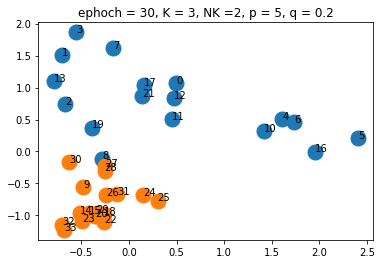

In [25]:
karatecheck(newpara)

In [27]:
# lamda = instance1.lamda
# K = instance1.K
# NK = instance1.NK
# LR = instance1.LR
# p = instance1.p
# q = instance1.q

In [29]:
# karatecheck(newpara1)